In [9]:
%matplotlib notebook
import numpy as np
import os
import gyrationZMagnet as gzm
from my_tools import get_next_name
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
import ROOT

In [2]:
loadpath = f'{gzm.savepath}smeared/'

In [3]:
pattern = 'rejOut_(\d*)_nonSmearedr_01\.csv'

In [4]:
files = [i for i in os.listdir(loadpath) if re.match(pattern,i)]

In [5]:
# files

### A single data file contains data from protons launched at the detector at a random small angle (to pass through both ends) at a single momentum. Each simulation data point (there's ~10 per file) has been smeared 1000 times and put into the file (with some outliers removed).

In [6]:
data = np.loadtxt(f'{loadpath}{files[0]}')

In [7]:
single_momenta, single_radii = data[:,0],data[:,1] # just picking columns

<IPython.core.display.Javascript object>


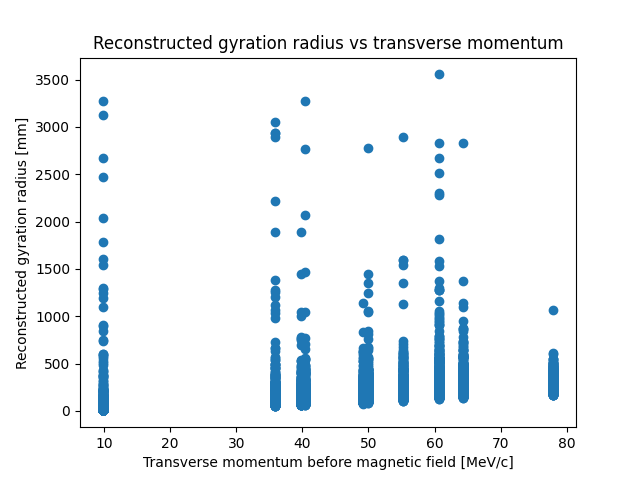

In [8]:
plt.figure(1)
plt.plot(single_momenta,single_radii,'o')
plt.title('Reconstructed gyration radius vs transverse momentum')
plt.xlabel('Transverse momentum before magnetic field [MeV/c]')
plt.ylabel('Reconstructed gyration radius [mm]')
plt.show()

### Pick a single column of this data. It represents the collection of smeared results for a single simulation data point. The transverse momentum is taken from the simulation and is unaffected by the smearing.

In [10]:
nbins = 250
dist_momenta = single_momenta[(single_momenta>58)&(single_momenta<63)]
dist_radii = single_radii[(single_momenta>58)&(single_momenta<63)]
y,bin_edges = np.histogram(dist_radii,bins=nbins)
x = (bin_edges[1:]+bin_edges[:-1])/2
# nbins = int(dist_radii.max()//1+1)

In [11]:
nbins

250

<IPython.core.display.Javascript object>


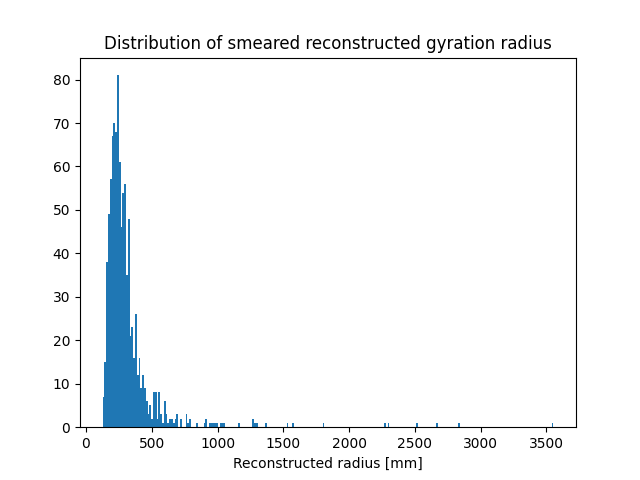

In [12]:
plt.figure(2)
plt.hist(dist_radii,bins=nbins)
plt.title('Distribution of smeared reconstructed gyration radius')
plt.xlabel('Reconstructed radius [mm]')
plt.show()

### PyLandau fit
This is here for completeness, it is not used anymore.

In [13]:
import pylandau
from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>


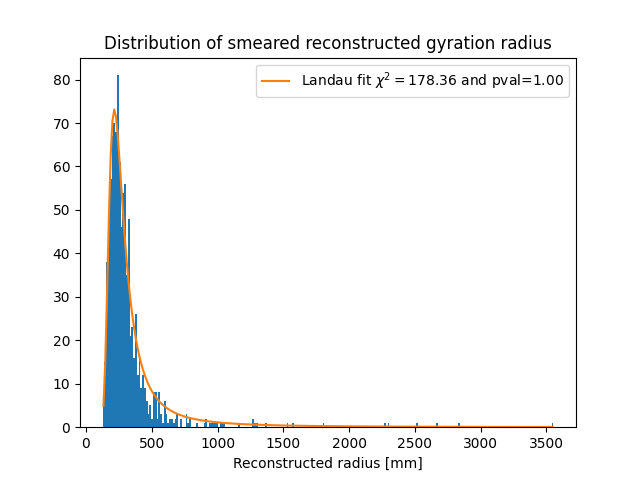

In [14]:
coeff, pcov = curve_fit(pylandau.landau, x, y,
                        absolute_sigma=True,
                        p0=[1,1,1],
                        bounds=(1, x.max()))
chi2,pval = stats.chisquare(y,f_exp=pylandau.landau(x, *coeff))
# Plot
plt.figure(4)
plt.hist(dist_radii,bins=nbins)
chi2l,pvall = stats.chisquare(y,f_exp=pylandau.landau(x, *coeff))
plt.plot(x, pylandau.landau(x, *coeff), "-",label=f'Landau fit $\chi^2=${chi2l:.2f} and pval={pvall:.2f}')
plt.legend()
plt.title('Distribution of smeared reconstructed gyration radius')
plt.xlabel('Reconstructed radius [mm]')
plt.show()

In [16]:
coeff

array([215.27585937,  37.21282044,  73.11773429])

### Landau fit with root

In [17]:
h = ROOT.TH1D("h","Distribution of smeared reconstructed gyration radius;Reconstructed radius [mm];;;",nbins,dist_radii.min(),dist_radii.max())

In [18]:
h.FillN(dist_radii.shape[0],dist_radii, np.ones_like(dist_radii))

In [19]:
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
h.Draw()

In [20]:
f1 = ROOT.TF1('f1','landau',dist_radii.min(),dist_radii.max())
f1.FixParameter(3,True)
fitresult = h.Fit('f1','S')

 FCN=87.8135 FROM MIGRAD    STATUS=CONVERGED     172 CALLS         173 TOTAL
                     EDM=1.71323e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.12317e+02   1.95479e+01   6.29363e-02   2.57709e-05
   2  MPV          2.14387e+02   2.34624e+00   1.00618e-02   3.26130e-04
   3  Sigma        3.19553e+01   1.16102e+00   1.33525e-05  -3.69750e-01


Trying another way to call a landau fit just to make sure I understood all parameters correctly.

In [21]:
f2 = ROOT.TF1('f2','[0]*ROOT::Math::landau_pdf(x,[1],[2])',dist_radii.min(),dist_radii.max())
f2.SetParameter(0,dist_radii.shape[0])
f2.SetParameter(0,1)
f2.SetParameter(2,0)
h.Fit('f2','S')

 FCN=87.8135 FROM MIGRAD    STATUS=CONVERGED     412 CALLS         413 TOTAL
                     EDM=2.26803e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   3.4 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.31755e+04   4.35305e+02  -9.72842e+00  -1.43901e-06
   2  p1           3.19560e+01   1.15415e+00   3.74610e-02  -4.81632e-04
   3  p2           2.14387e+02   2.37426e+00   9.88414e-03   2.14900e-04


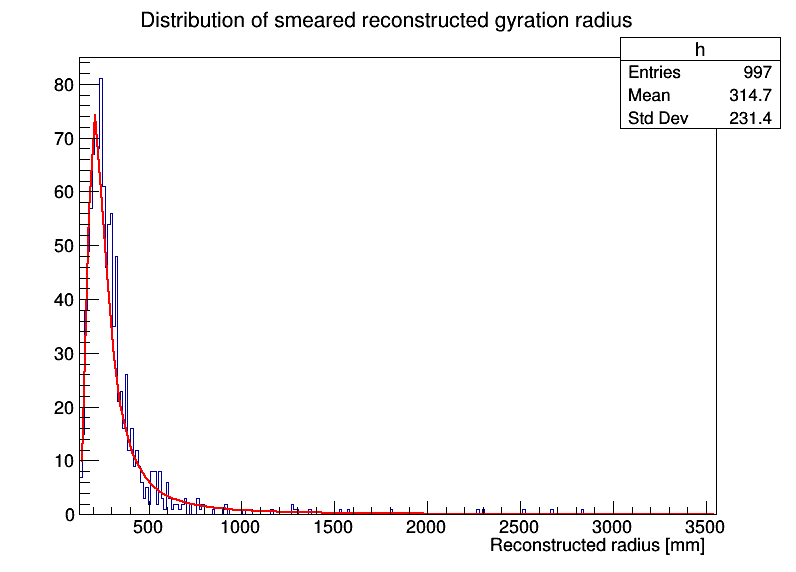

In [22]:
h.Draw()
c.Update()
c.Draw()

Now the square root of the variation (second moment) should 

In [23]:
np.sqrt(ROOT.Math.landau_xm2(dist_radii.max(),f1.GetParameter(2),f1.GetParameter(1)))

470.9629015744016

In [24]:
np.sqrt(ROOT.Math.landau_xm2(dist_radii.max(),f2.GetParameter(1),f2.GetParameter(2)))

470.9670754495643

Sanity check, the way I understand it the pdf at the maximum should be at least close to 1

In [25]:
ROOT.Math.landau_cdf(bin_edges[-1],f1.GetParameter(2),f1.GetParameter(1))

0.9900358266928445

In [26]:
ROOT.Math.landau_cdf(dist_radii.max(),f2.GetParameter(1),f2.GetParameter(2))

0.9900355929796024

In [63]:
fitresult.Chi2()

87.81349580959734

In [28]:
bin1 = h.FindFirstBinAbove(h.GetMaximum()/2);
bin2 = h.FindLastBinAbove(h.GetMaximum()/2);
fwhm = h.GetBinCenter(bin2) - h.GetBinCenter(bin1);

In [29]:
bin1,bin2

(4, 15)

In [30]:
h.GetBinCenter(bin1),h.GetBinCenter(bin2),h.Get

(173.86103986428367, 324.71395775545125)

In [42]:
g1 = ROOT.TF1('g1','gaus',h.GetBinLowEdge(bin1),h.GetBinLowEdge(bin2+1))
fitresult = h.Fit('g1','SR')

 FCN=13.5901 FROM MIGRAD    STATUS=CONVERGED      99 CALLS         100 TOTAL
                     EDM=5.60881e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.63697e+01   3.64735e+00   4.75201e-03   9.41537e-05
   2  Mean         2.30169e+02   7.71455e+00   1.14128e-02  -1.38405e-05
   3  Sigma        8.61351e+01   1.33935e+01   8.42466e-05   4.46716e-03


In [41]:
g1.GetParameter(1)

230.16894035382822

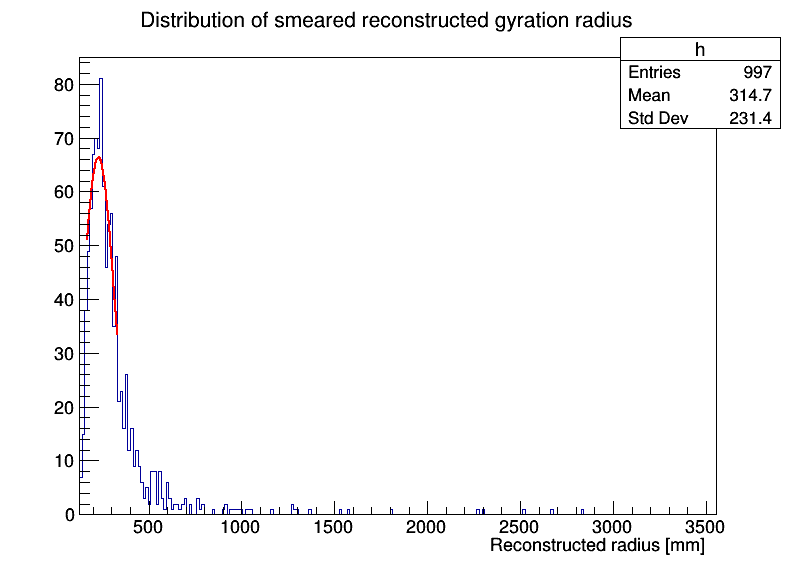

In [39]:
h.Draw()
c.Update()
c.Draw()

In [40]:
g1.GetChisquare()

13.59011838202639

In [45]:
fitresult.Chi2()

13.59011838202639

In [46]:
fitresult.Ndf()

9